# VAR 

In [1]:
pip install statsmodels==0.12.2

In [2]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [10, 7.5]

## United Kingdom Macroeconomic Dataset 

In [4]:
#macro_data = sm.datasets.macrodata.load_pandas()
#macro_data = macro_data.data
#macro_data.head()

In [5]:
url='https://raw.githubusercontent.com/nzxtdata/Multivariate-Financial-Time-Series-Forecasting-with-Machine-Learning/main/FTSEfundamental.csv'
df1 = pd.read_csv(url, parse_dates= True)
df1['Date'] = pd.to_datetime(df1['Date'])
df1.set_index('Date', inplace=True)

macro_data=df1.copy()
macro_data=macro_data.asfreq('b')
macro_data=macro_data.fillna(method='ffill')
macro_data['returns'] = macro_data.ftseclose.pct_change(1).mul(100)
macro_data = macro_data.iloc[1:]
macro_data=macro_data[macro_data.index < '2020-12-01']

In [6]:
#macro_data = macro_data.resample('28D').interpolate()

In [7]:
#macro_data=macro_data.loc['1994-03-31':'2020-02-01']


In [8]:
macro_data['returns'] = macro_data.ftseclose.pct_change(1).mul(100)
macro_data = macro_data.iloc[1:]

In [9]:
macro_data

,ftseopen,ftsehigh,ftselow,ftseclose,ftsevolume,fwd_6mo_usd_to_gbp,10yr_treasury_yield,uk_gdp_qoq_cvm_sa_growth_%,uk_unemployment_sa_%,uk_longterm_ir_%,returns
Date,,,,,,,,,,,
1994-04-04,3086.399902,3086.399902,3086.399902,3086.399902,0.000000e+00,1.4757,7.5876,1.2,9.8,6.851200,0.000000
1994-04-05,3060.899902,3116.199951,3047.000000,3116.199951,0.000000e+00,1.4757,7.5876,1.2,9.8,6.851200,0.965528
1994-04-06,3142.800049,3145.399902,3129.600098,3131.500000,0.000000e+00,1.4757,7.5876,1.2,9.8,6.851200,0.490984
1994-04-07,3133.399902,3143.500000,3117.000000,3129.000000,0.000000e+00,1.4757,7.5876,1.2,9.8,6.851200,-0.079834
1994-04-08,3137.800049,3138.000000,3118.800049,3120.800049,0.000000e+00,1.4757,7.5876,1.2,9.8,6.851200,-0.262063
...,...,...,...,...,...,...,...,...,...,...,...
2020-11-24,6333.799805,6432.399902,6333.700195,6432.200195,1.301561e+09,1.2374,0.8347,-19.5,3.8,0.303333,1.553576
2020-11-25,6432.200195,6468.700195,6375.299805,6391.100098,1.129314e+09,1.2374,0.8347,-19.5,3.8,0.303333,-0.638974
2020-11-26,6391.100098,6412.700195,6349.500000,6362.899902,7.362725e+08,1.2374,0.8347,-19.5,3.8,0.303333,-0.441242


Text(0.5, 1.0, '10yr_treasury_yield')

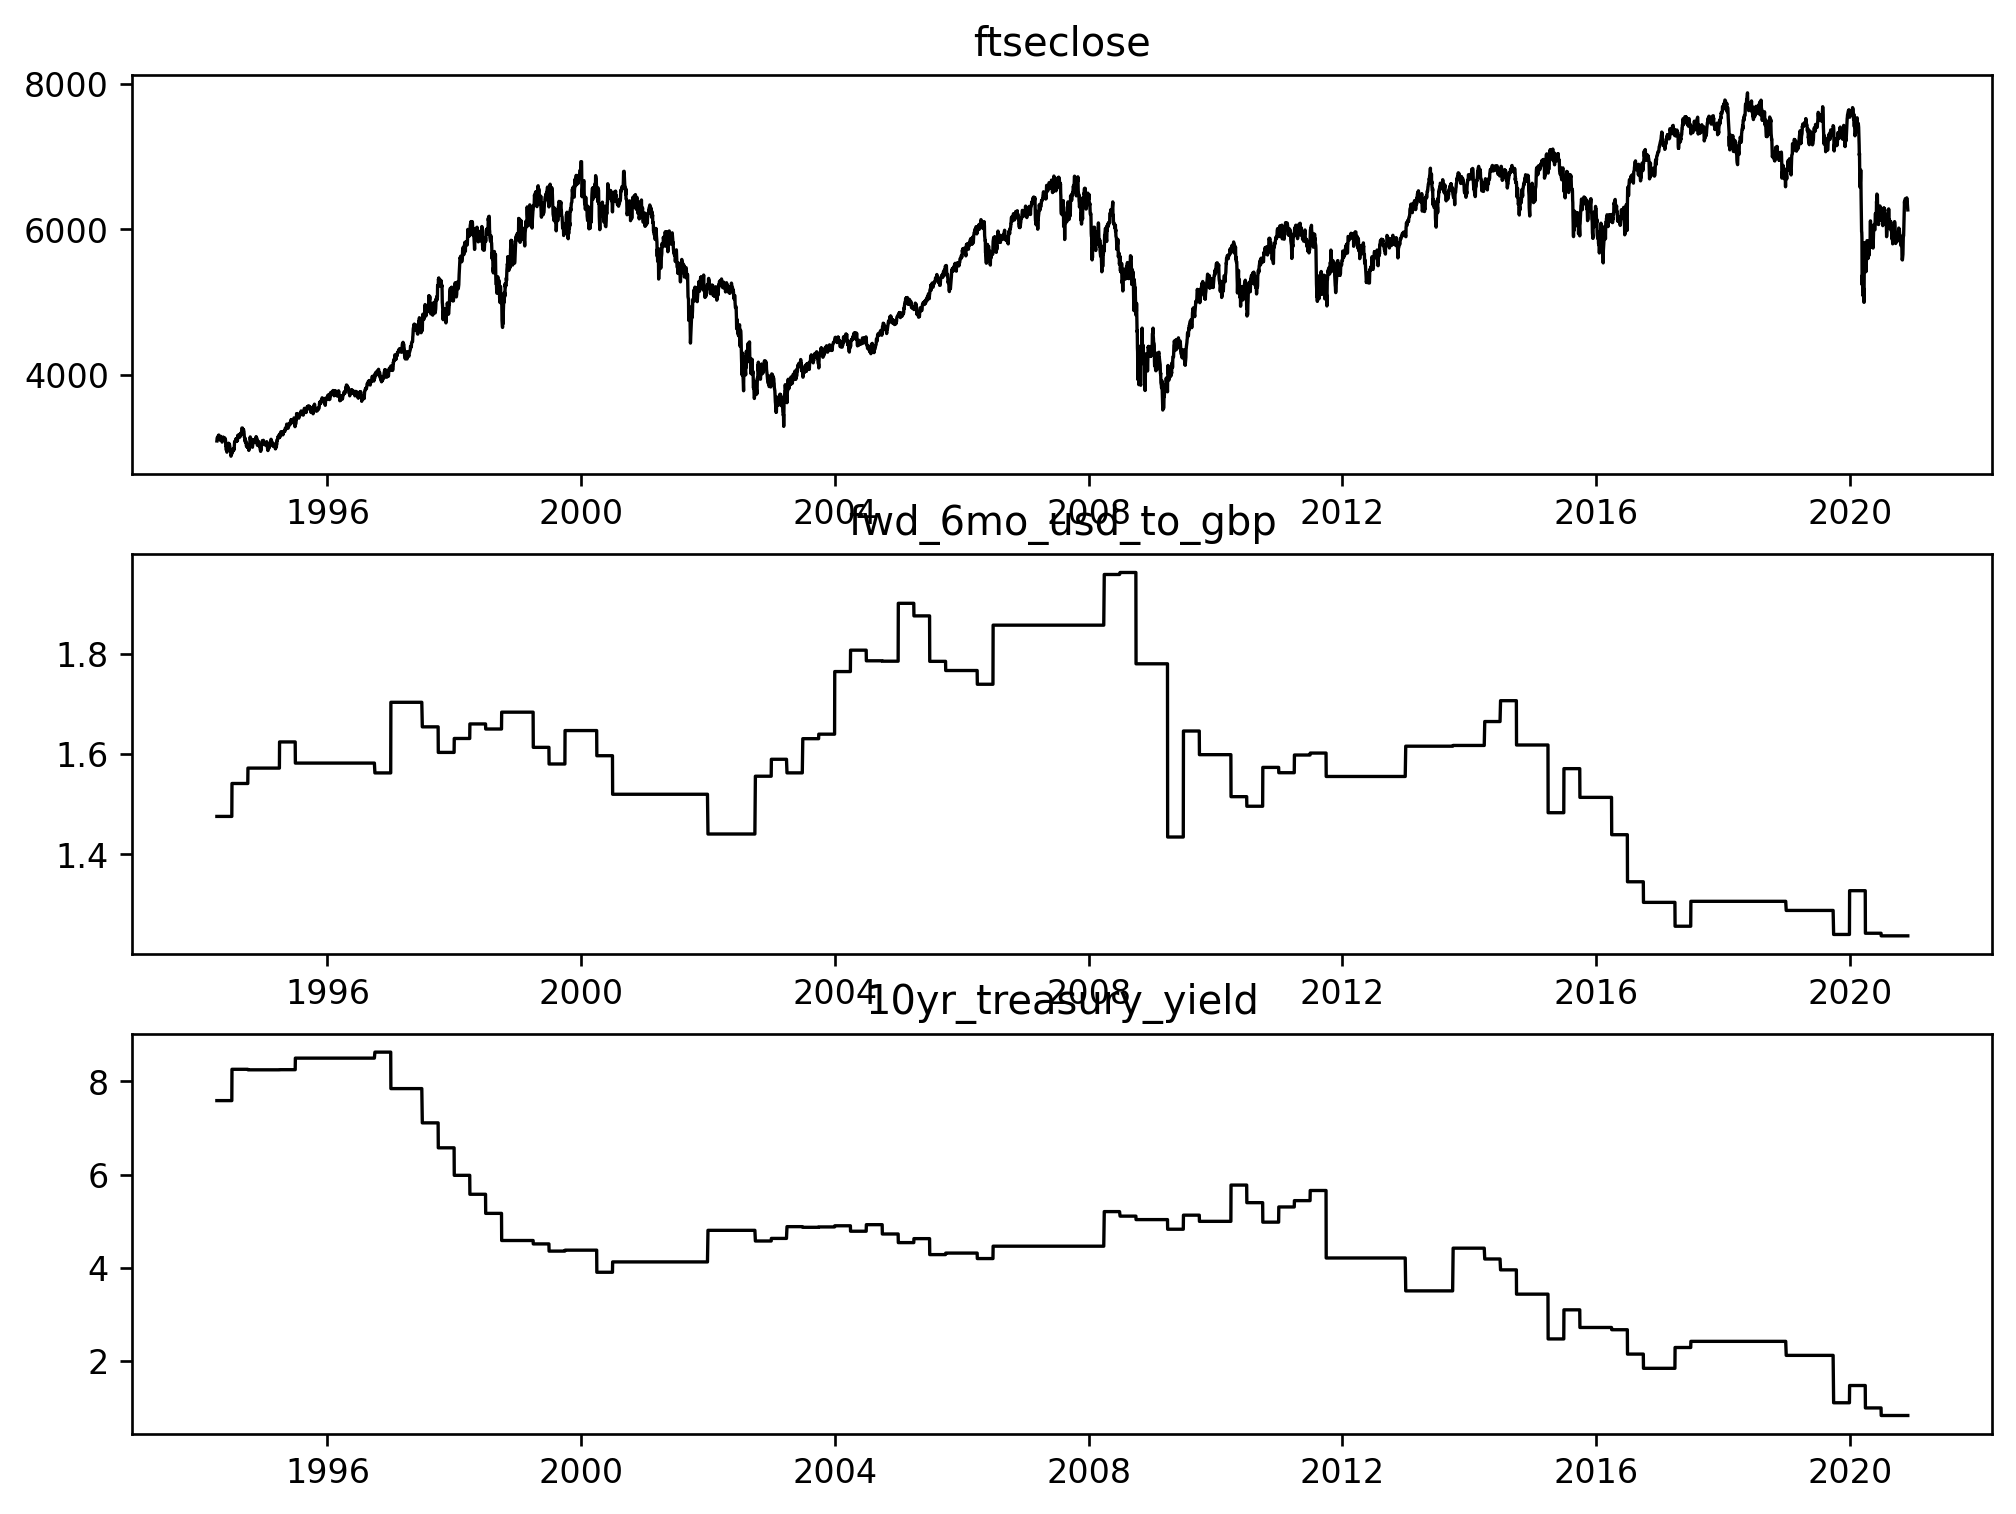

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, dpi=240)

ax1.plot(macro_data['ftseclose'], color='black', linewidth=1)
ax1.set_title('ftseclose')
#ax1.xaxis.set_ticks_position('none')
#ax1.yaxis.set_ticks_position('none')
#ax1.spines['top'].set_alpha(0)
#ax1.tick_params(labelsize=6)

ax2.plot(macro_data['fwd_6mo_usd_to_gbp'], color='black', linewidth=1)
ax2.set_title('fwd_6mo_usd_to_gbp')
#ax2.xaxis.set_ticks_position('none')
#ax2.yaxis.set_ticks_position('none')
#ax2.spines['top'].set_alpha(0)
#ax2.tick_params(labelsize=6)

ax3.plot(macro_data['10yr_treasury_yield'], color='black', linewidth=1)
ax3.set_title('10yr_treasury_yield')

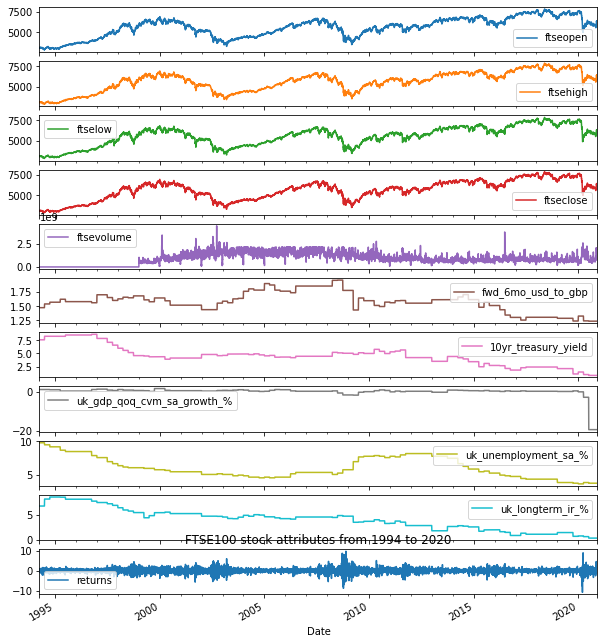

In [11]:
macro_data['1994':'2020'].plot(subplots=True, figsize=(10,12))
plt.title('FTSE100 stock attributes from 1994 to 2020')
plt.savefig('stocks.png')
plt.show()

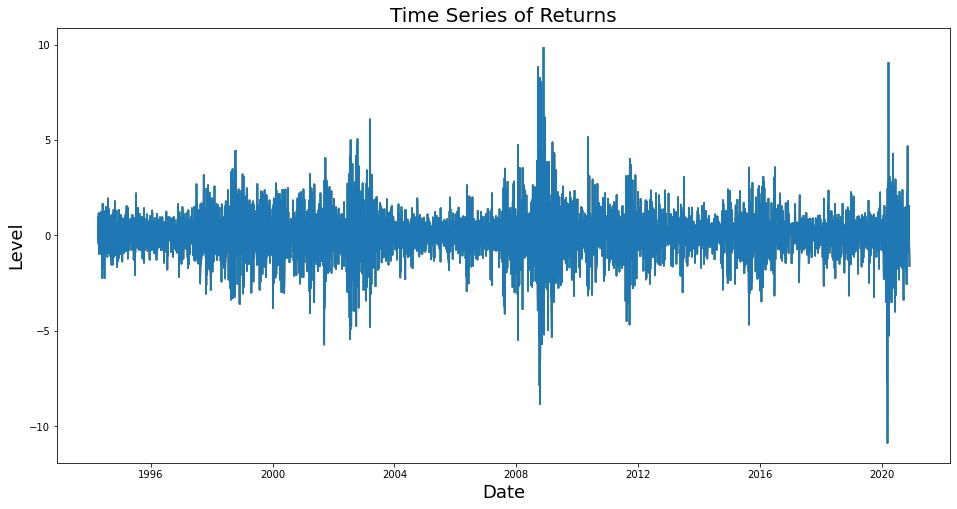

In [12]:
series = list(macro_data.columns)
fig, ax = plt.subplots(figsize = (16,8))
for series in series:
    x = macro_data.index
    y = macro_data['returns']
    ax.plot(x, y, label=series)
ax.legend(fontsize=12)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Level', fontsize=18)
plt.title('Time Series of Returns', fontsize=20)
ax.get_legend().remove()

plt.show()

In [13]:
ad_fuller_result_1 = adfuller(macro_data['ftseclose'].diff()[1:])

print('ftseclose')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_data['fwd_6mo_usd_to_gbp'].diff()[1:])

print('fwd_6mo_usd_to_gbp')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

ftseclose
ADF Statistic: -28.225713356223274
p-value: 0.0

---------------------

fwd_6mo_usd_to_gbp
ADF Statistic: -83.38017488425206
p-value: 0.0


In [14]:
def optimize_VAR(endog):
    """
        Returns a dataframe with parameters and corresponding MSE
        
        endog - observed time series
    """
    
    results = []
    
    for i in tqdm_notebook(range(6)):
        try:
            model = VARMAX(endog, order=(i, 0)).fit(dips=False)
        except:
            continue
            
        mse = model.mse
        results.append([i, mse])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'mse']
    
    result_df = result_df.sort_values(by='mse', ascending=True).reset_index(drop=True)
    
    return result_df

In [15]:
macro_data.columns

Index(['ftseopen', 'ftsehigh', 'ftselow', 'ftseclose', 'ftsevolume',
       'fwd_6mo_usd_to_gbp', '10yr_treasury_yield',
       'uk_gdp_qoq_cvm_sa_growth_%', 'uk_unemployment_sa_%',
       'uk_longterm_ir_%', 'returns'],
      dtype='object')

[15:22:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


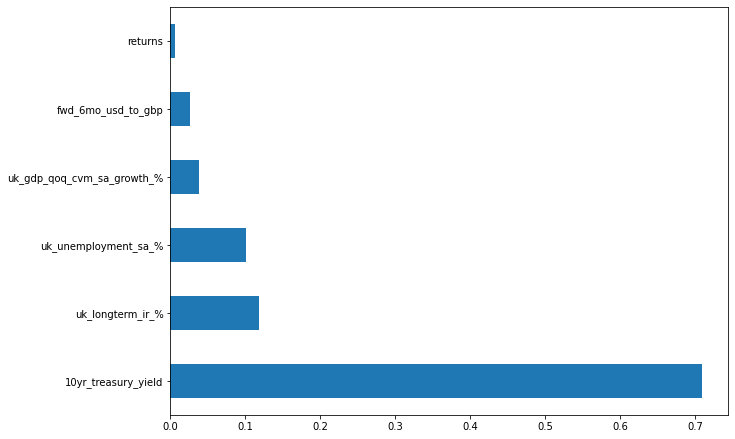

In [16]:
from numpy import loadtxt
from xgboost import XGBRegressor
from matplotlib import pyplot

model = XGBRegressor()
model.fit(macro_data[[ 'fwd_6mo_usd_to_gbp', '10yr_treasury_yield',
       'uk_gdp_qoq_cvm_sa_growth_%', 'uk_unemployment_sa_%',
       'uk_longterm_ir_%','returns']], macro_data[['ftseclose']])

(pd.Series(model.feature_importances_, index=macro_data[['fwd_6mo_usd_to_gbp', '10yr_treasury_yield',
       'uk_gdp_qoq_cvm_sa_growth_%', 'uk_unemployment_sa_%',
       'uk_longterm_ir_%','returns']].columns)
   .nlargest(7)
   .plot(kind='barh'))

In [17]:
macro_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6956 entries, 1994-04-04 to 2020-11-30
Freq: B
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ftseopen                    6956 non-null   float64
 1   ftsehigh                    6956 non-null   float64
 2   ftselow                     6956 non-null   float64
 3   ftseclose                   6956 non-null   float64
 4   ftsevolume                  6956 non-null   float64
 5   fwd_6mo_usd_to_gbp          6956 non-null   float64
 6   10yr_treasury_yield         6956 non-null   float64
 7   uk_gdp_qoq_cvm_sa_growth_%  6956 non-null   float64
 8   uk_unemployment_sa_%        6956 non-null   float64
 9   uk_longterm_ir_%            6956 non-null   float64
 10  returns                     6956 non-null   float64
dtypes: float64(11)
memory usage: 972.1 KB


In [18]:
macro_data.describe()

,ftseopen,ftsehigh,ftselow,ftseclose,ftsevolume,fwd_6mo_usd_to_gbp,10yr_treasury_yield,uk_gdp_qoq_cvm_sa_growth_%,uk_unemployment_sa_%,uk_longterm_ir_%,returns
count,6956.000000,6956.000000,6956.000000,6956.000000,6.956000e+03,6956.000000,6956.000000,6956.000000,6956.000000,6956.000000,6956.000000
mean,5605.222886,5642.225504,5567.387322,5605.791761,8.901920e+08,1.580563,4.541388,0.133324,6.088801,4.130768,0.016609
std,1186.991063,1191.023355,1183.092237,1186.817520,6.033548e+08,0.173458,1.824337,2.564517,1.537758,2.179743,1.132945
min,2844.699951,2902.199951,2844.699951,2876.600098,0.000000e+00,1.237400,0.834700,-19.500000,3.700000,0.303333,-10.873819
25%,4755.650146,4793.050171,4723.850098,4756.400024,5.590378e+08,1.513700,3.507200,0.300000,4.900000,2.586967,-0.510723
50%,5827.000000,5866.650146,5778.699951,5827.849854,8.269698e+08,1.582100,4.465500,0.400000,5.500000,4.458034,0.009153
75%,6465.750122,6511.275024,6423.849854,6466.275146,1.306722e+09,1.665000,5.035700,0.700000,7.700000,5.311433,0.572055
max,7877.500000,7903.500000,7854.600098,7877.500000,4.420947e+09,1.962400,8.627300,1.700000,9.800000,8.693767,9.838667


In [19]:
endog = macro_data[['ftseclose', '10yr_treasury_yield', 'uk_unemployment_sa_%',
       'uk_longterm_ir_%','fwd_6mo_usd_to_gbp','uk_gdp_qoq_cvm_sa_growth_%','returns']]

In [20]:


result_df = optimize_VAR(endog)
result_df

,p,mse
0,5,4571.839316
1,4,4591.932135
2,3,4599.686961
3,2,4615.960876
4,1,4627.462907


In [21]:
best_model = VARMAX(endog, order=(5,0))
res = best_model.fit(disp=False)
print(res.summary())

                                                                                          Statespace Model Results                                                                                         
Dep. Variable:     ['ftseclose', '10yr_treasury_yield', 'uk_unemployment_sa_%', 'uk_longterm_ir_%', 'fwd_6mo_usd_to_gbp', 'uk_gdp_qoq_cvm_sa_growth_%', 'returns']   No. Observations:                 6956
Model:                                                                                                                                                      VAR(5)   Log Likelihood               27297.792
                                                                                                                                                       + intercept   AIC                         -54035.583
Date:                                                                                                                                             Thu, 29 Jul 2021   BIC                

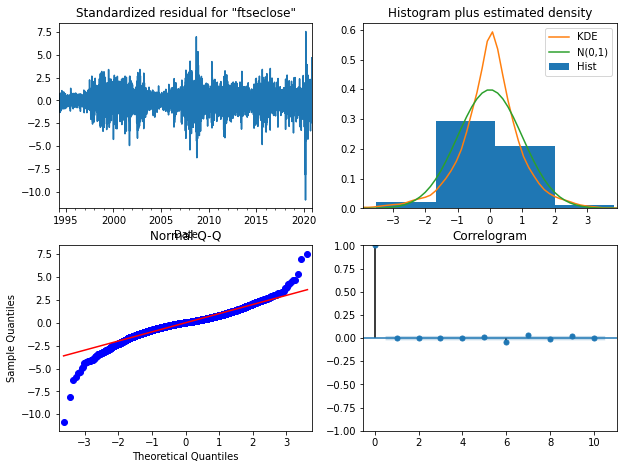

In [22]:
res.plot_diagnostics();

In [24]:
n_forecast = 30
predict = res.get_prediction(end=best_model.nobs + n_forecast)
idx = np.arange(len(predict.predicted_mean))

predict.predicted_mean.tail(3)

,ftseclose,10yr_treasury_yield,uk_unemployment_sa_%,uk_longterm_ir_%,fwd_6mo_usd_to_gbp,uk_gdp_qoq_cvm_sa_growth_%,returns
2021-01-08,6173.327234,0.876093,3.884961,0.285894,1.229789,-19.920585,-0.047157
2021-01-11,6169.979396,0.877570,3.887927,0.285267,1.229539,-19.934723,-0.047029
2021-01-12,6166.637818,0.879050,3.890895,0.284643,1.229289,-19.948868,-0.046899


In [25]:
macro_data.shape

(6956, 11)

In [26]:
macro_date_show = macro_data[macro_data.index >= '2020-11-01']
true_vals = df1[(df1.index >= '2020-12-01') & (df1.index < '2021-01-01')]

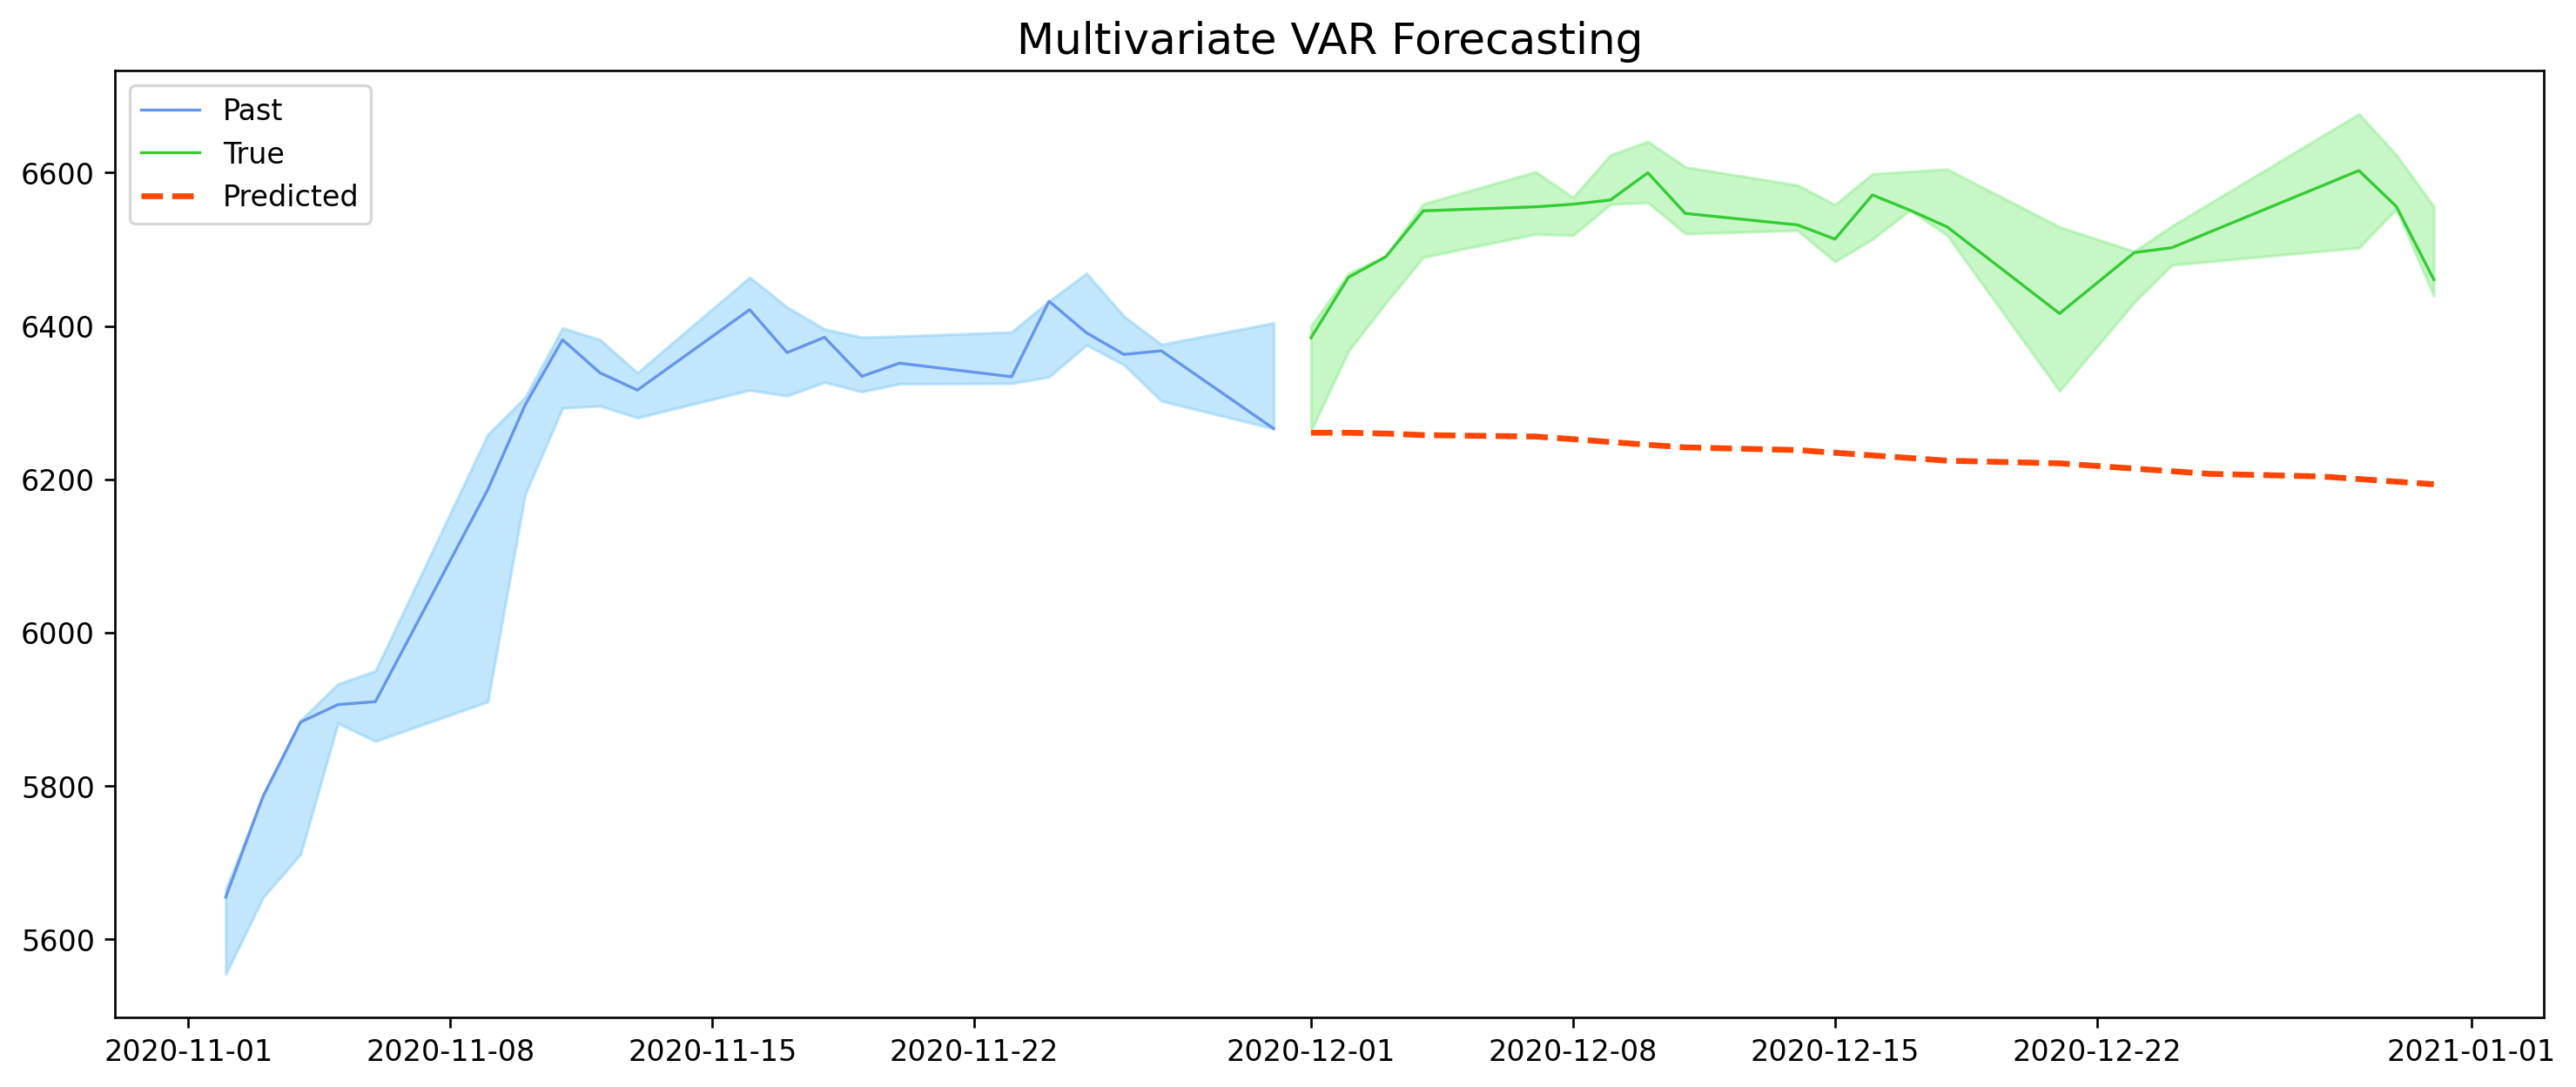

In [27]:
fig, ax1 = plt.subplots(dpi=240,figsize=(15,6))

ax1.plot(macro_date_show['ftseclose'], color='cornflowerblue', linewidth=1, label='Past')
ax1.plot(true_vals['ftseclose'], color='limegreen', linewidth=1, label='True')


ax1.plot(predict.predicted_mean.index[-31:-8], 
         predict.predicted_mean['ftseclose'][-31:-8], 
         color='orangered', 
         ls='--',
         linewidth=2, label='Predicted')

ax1.fill_between(macro_date_show.index, macro_date_show.ftselow, macro_date_show.ftsehigh, color='lightskyblue', alpha=0.5)
ax1.fill_between(true_vals.index, true_vals.ftselow, true_vals.ftsehigh, color='lightgreen', alpha=0.5)

ax1.set_title("Multivariate VAR Forecasting", size = 15)
ax1.legend()

plt.show()

In [29]:
test_df = true_vals.resample('D').mean()[['ftseclose']]
test_df['preds'] = predict.predicted_mean[['ftseclose']][-31:-8].resample('D').mean().values

test_df = test_df.dropna()

In [30]:
from sklearn import metrics
def timeseries_evaluation_metrics_func(y_true, y_pred):
    
    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [31]:
timeseries_evaluation_metrics_func(test_df.ftseclose, test_df.preds)

Evaluation metric results:-
MSE is : 86935.9784151927
MAE is : 288.42070384071064
RMSE is : 294.8490773517745
MAPE is : 4.414917790780459
R2 is : -26.969196809890246

